In [1]:
#@title Imports and defaults
%matplotlib inline

import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import sys

sys.path.append("..")

mpl.style.use("classic")
mpl.rcParams["figure.figsize"] = [5, 3]

mpl.rcParams["axes.linewidth"] = 0.75
mpl.rcParams["grid.linewidth"] = 0.75
mpl.rcParams["lines.linewidth"] = 0.75
mpl.rcParams["patch.linewidth"] = 0.75
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 7
mpl.rcParams["axes.titlesize"] = "medium"
mpl.rcParams["legend.fontsize"] = "medium"

import platform
print("python %s" % platform.python_version())
print("matplotlib %s" % mpl.__version__)

from simulator import *
from algorithms import *
from deep import *

'''
from colabtools import adhoc_import
with adhoc_import.Google3CitcClient("bandits", "bkveton"):
  from google3.experimental.users.bkveton.bandits.simulator import *
  from google3.experimental.users.bkveton.bandits.algorithms import *
  from google3.experimental.users.bkveton.bandits.phe import *
  from google3.experimental.users.bkveton.bandits.deep import *
'''

def linestyle2dashes(style):
  if style == "--":
    return (3, 3)
  elif style == ":":
    return (0.5, 2.5)
  else:
    return (None, None)

python 3.6.9
matplotlib 3.2.1
Instructions for updating:
non-resource variables are not supported in the long term


python 3.6.9
tf 2.2.0
keras 2.3.0-tf
Preprocessing dataset mnist...
60000 examples, 784 features, 10 labels
Evaluating DeepFPLWARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
.......... 423.0 seconds
Regret: 4656.30 +/- 52.96 (median: 4629.50, max: 5015.00, min: 4411.00)
Reward in last 1000 rounds: 477.80 +/- 5.10
Evaluating DeepFPL.......... 429.4 seconds
Regret: 5056.10 +/- 61.95 (median: 4949.50, max: 5467.00, min: 4873.00)
Reward in last 1000 rounds: 525.90 +/- 6.18
Evaluating Deep History Swapping.......... 454.2 seconds
Regret: 4985.80 +/- 38.91 (median: 4962.50, max: 5184.00, min: 4756.00)
Reward in last 1000 rounds: 518.60 +/- 6.21


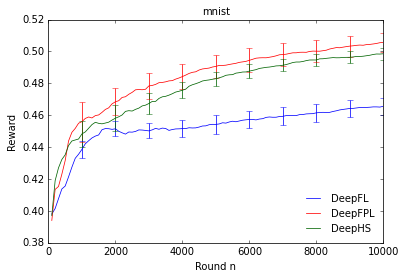

python 3.6.9
tf 2.2.0
keras 2.3.0-tf
Preprocessing dataset fashion_mnist...
60000 examples, 784 features, 10 labels
Evaluating DeepFPL.......... 425.3 seconds
Regret: 4655.90 +/- 59.17 (median: 4630.50, max: 4924.00, min: 4286.00)
Reward in last 1000 rounds: 483.10 +/- 7.17
Evaluating DeepFPL.......... 431.9 seconds
Regret: 4810.50 +/- 134.71 (median: 5000.00, max: 5146.00, min: 3746.00)
Reward in last 1000 rounds: 504.50 +/- 16.38
Evaluating Deep History Swapping.......... 452.8 seconds
Regret: 4783.80 +/- 79.20 (median: 4806.50, max: 5068.00, min: 4330.00)
Reward in last 1000 rounds: 497.70 +/- 7.67


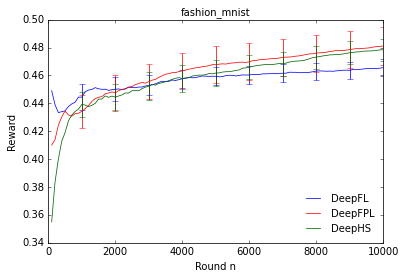

In [2]:
# experiments
num_runs = 10
n = 10000

# neural nets
hidden_nodes = "50-50"
hidden_activation = "relu"
optimizer = "adam"
lr = 0.001
batch_size = 32
deeps = [
  ("DeepFPL",
  {"hidden_nodes": hidden_nodes, "hidden_activation": hidden_activation,
  "optimizer": optimizer, "lr": lr, "batch_size": batch_size},
  "blue", "-", "DeepFL"),
  ("DeepFPL",
  {"hidden_nodes": hidden_nodes, "hidden_activation": hidden_activation,
  "optimizer": optimizer, "lr": lr, "batch_size": batch_size, "a": 1.0},
  "red", "-", "DeepFPL"),
  # ("NeuralLinear",
  # {"hidden_nodes": hidden_nodes, "hidden_activation": hidden_activation,
  # "lr": lr, "batch_size": batch_size, "a": 1.0, "relepe": int(0.05 * n)},
  # "cyan", "-", "NeuralLinear 5%"),
  ("DeepHS",
  {"hidden_nodes": hidden_nodes, "hidden_activation": hidden_activation,
  "optimizer": optimizer, "lr": lr, "batch_size": batch_size, "swap_prob": 0.5},
  "darkgreen", "-", "DeepHS"),
]

step = 100 * (np.arange(n // 100) + 1)
sube = (step.size // 10) * np.arange(1, 11) - 1

for dataset in ["mnist", "fashion_mnist"]:
  # create environment
  X, y = load_dataset(dataset,1)
  num_labels = int(y.max()) + 1

  for alg in deeps:
    env = []
    for run in range(num_runs):
      c = run % num_labels
      env.append(BinaryClassBandit(X, y, pos_label=c, K=10, pos_prob=0.65))

    alg_class = globals()[alg[0]]
    reward, _ = evaluate(alg_class, alg[1], env, n)
    print("Reward in last %d rounds: %.2f +/- %.2f" %
      (n // 10, reward[- n // 10 :, :].sum(axis=0).mean(), \
      reward[- n // 10 :, :].sum(axis=0).std() / np.sqrt(num_runs)))

    cum_reward = reward.cumsum(axis=0)[step - 1, :] / step[:, np.newaxis]
    plt.plot(step, cum_reward.mean(axis=1),
      alg[2], dashes=linestyle2dashes(alg[3]), label=alg[4])
    plt.errorbar(step[sube], cum_reward[sube, :].mean(axis=1),
      cum_reward[sube, :].std(axis=1) / np.sqrt(cum_reward.shape[1]),
      fmt="none", ecolor=alg[2])

  plt.title("%s" % dataset)
  plt.xlabel("Round n")
  plt.ylabel("Reward")
  plt.legend(loc="lower right", frameon=False)
  plt.show()